# ME5413: Autonomous Mobile Robot  

### Homework 1: Perception  
Due date: 22 February 2024 (Thurs) - 2359 

### Task 1.1 Single-Object Tracking 

#### Preparation

**Import the necessary packages**

In [1]:
import cv2
import numpy as np
import glob
from utils.load import *
from utils.save import save_detections
from utils.evaluate import *

**Load (and Test) the original frames**

The original frames are stored in the folder `./data`. I define the variable `images` to store the original frames, and then use `cv2.imshow()` to display the original videos.

In [2]:
# parameters to be set
seq_index = "4"
is_limit_region = True
is_scale = False

# load the frames
seq_folder_path = 'data/seq_' + seq_index
image_files = glob.glob(seq_folder_path + '/img' + '/*.jpg')
image_files.sort()

images = []
for image_files in image_files:
    image = cv2.imread(image_files)
    images.append(image)

# # test the display
# for img in images:
#     cv2.imshow('image', img)
#     if cv2.waitKey(50) & 0xFF == ord('q'):
#         break

cv2.destroyAllWindows()

#### Using Template Matching
1. Create a template from the first frame.
2. Use the template to find the object in the subsequent frames. It should be noticed that there are vavious built-in methods for template matching in OpenCV:
    + TM_SQDIFF
    + **TM_SQDIFF_NORMED**
    + TM_CCORR
    + TM_CCORR_NORMED
    + **TM_CCOEFF**
    + TM_CCOEFF_NORMED
3. Draw the rectangle which is the matched region on the original frame (I don't want to change the original frame, so I use the `copy()` method to create a new frame to draw the rectangle)
4. Display the frames with the rectangle.

In [3]:
# Create a template from the first frame
x, y, w, h = load_firsttrack(seq_folder_path + '/firsttrack.txt')
template = images[0][y:y+h, x:x+w]

# Define a list of scales for resizing the template
wh_scales = []

# Define the extended region of template matching
limit_region = [100, 100, 100, 100] # [left, top, right, bottom]

# Definie the extended region of template matching
# Select matching method based on the seq_folder_path
if seq_folder_path == 'data/seq_1':
    matching_method = cv2.TM_CCOEFF_NORMED # TM_CCOEFF_NORMED > TM_CCORR_NORMED > TM_CCOEFF
    wh_scales = [[1.0, 1.0], [0.9, 1.0], [0.8, 1.0]]
    limit_region = [1, 5, 12, 1]
elif seq_folder_path == 'data/seq_2':
    matching_method = cv2.TM_SQDIFF_NORMED # TM_SQDIFF> TM_CCOEFF > TM_CCOEFF_NORMED > TM_SQDIFF_NORMED > TM_CCORR_NORMED
    wh_scales = [[1.0, 1.0], [1.0, 0.9], [0.9, 1.0]]
    limit_region = [2, 1, 1, 1]
elif seq_folder_path == 'data/seq_3':
    matching_method = cv2.TM_CCORR_NORMED
    wh_scales = [[1.0, 1.0]]
    limit_region = [5, 1, 8, 1]
elif seq_folder_path == 'data/seq_4':
    matching_method = cv2.TM_CCOEFF_NORMED
    wh_scales = [[1.0, 1.0]]
    limit_region = [1, 1, 50, 5]
elif seq_folder_path == 'data/seq_5':
    matching_method = cv2.TM_CCOEFF
    wh_scales = [[1.0, 1.0]]
    limit_region = [10, 10, 10, 10]
else:
    matching_method = cv2.TM_CCOEFF_NORMED  # Default method
    wh_scales = [[1.0, 1.0]]
    limit_region = [100, 100, 100, 100]

if not is_limit_region:
    limit_region = [1000, 1000, 1000, 1000]

if not is_scale:
    wh_scales = [[1.0, 1.0]]

In [4]:
# Initialize the list to store the detections
detections = []

# Store the previous location
prev_loc = (x, y)

for img in images:
    # Initialize variables to store the best match
    best_match = None 
    best_val = -np.inf
    best_scale = (None, None)

    # Define the region for template matching
    x_region = max(0, prev_loc[0] - limit_region[0])
    y_region = max(0, prev_loc[1] - limit_region[1])
    w_region = min(img.shape[1] - 1, prev_loc[0] + w + limit_region[2]) - x_region
    h_region = min(img.shape[0] - 1, prev_loc[1] + h + limit_region[3]) - y_region

    for width_scale, height_scale in wh_scales:
        # Resize the template
        resized_template = cv2.resize(template, (0,0), fx=width_scale, fy=height_scale)

        # Template matching
        # res = cv2.matchTemplate(img, resized_template, matching_method)
        res = cv2.matchTemplate(img[y_region:y_region+h_region, x_region:x_region+w_region], resized_template, matching_method)
        _, max_val, _, max_loc = cv2.minMaxLoc(res)
        max_loc = (max_loc[0] + x_region, max_loc[1] + y_region)

        # If this match is better than the previous best, update the best match
        if max_val > best_val:
            best_val = max_val
            best_match = max_loc
            best_scale = (width_scale, height_scale)

    # copy the image
    img_copy = img.copy()

    # Draw rectangle around found location
    top_left = best_match
    bottom_right = (top_left[0] + int(w*best_scale[0]), top_left[1] + int(h*best_scale[1]))
    cv2.rectangle(img_copy, top_left, bottom_right, 255, 2)

    # Draw rectangle of the template matching region
    cv2.rectangle(img_copy, (x_region, y_region), (x_region+w_region, y_region+h_region), 0, 2)

    # Store the detections
    detections.append((top_left[0], top_left[1], int(w*best_scale[0]), int(h*best_scale[1])))

    cv2.imshow('image', img_copy)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

    # update the previous location
    prev_loc = (top_left[0], top_left[1])

cv2.destroyAllWindows()

# After processing all frames, save the detections to a text file
save_detections(detections,  seq_folder_path + '/detections_tm_im.txt')

QObject::moveToThread: Current thread (0x15caa60) is not the object's thread (0x16a8eb0).
Cannot move to target thread (0x15caa60)

QObject::moveToThread: Current thread (0x15caa60) is not the object's thread (0x16a8eb0).
Cannot move to target thread (0x15caa60)

QObject::moveToThread: Current thread (0x15caa60) is not the object's thread (0x16a8eb0).
Cannot move to target thread (0x15caa60)

QObject::moveToThread: Current thread (0x15caa60) is not the object's thread (0x16a8eb0).
Cannot move to target thread (0x15caa60)

QObject::moveToThread: Current thread (0x15caa60) is not the object's thread (0x16a8eb0).
Cannot move to target thread (0x15caa60)

QObject::moveToThread: Current thread (0x15caa60) is not the object's thread (0x16a8eb0).
Cannot move to target thread (0x15caa60)

QObject::moveToThread: Current thread (0x15caa60) is not the object's thread (0x16a8eb0).
Cannot move to target thread (0x15caa60)

QObject::moveToThread: Current thread (0x15caa60) is not the object's thread

**Evaluate the performance of the Single object tracking algorithm.**

Evaluate the performance of template matching and Kalman filter. The evaluation should include the following:
+ The accuracy of the tracking algorithm
+ The robustness of the tracking algorithm
+ The efficiency of the tracking algorithm


In [5]:
# Load the ground truth and the detections
groundtruth = load_tracks(seq_folder_path + '/groundtruth.txt')
detections_tm = load_tracks(seq_folder_path + '/detections_tm_im.txt')

# Return the average IoU
average_iou_tm = evaluate_average_iou(detections_tm, groundtruth)
average_distance = calculate_average_distance(detections_tm, groundtruth)


**Visualise the results as well**.


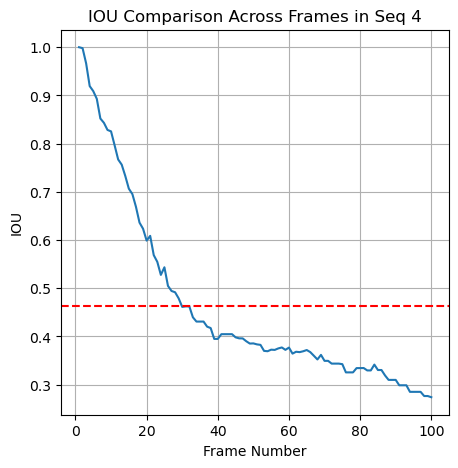

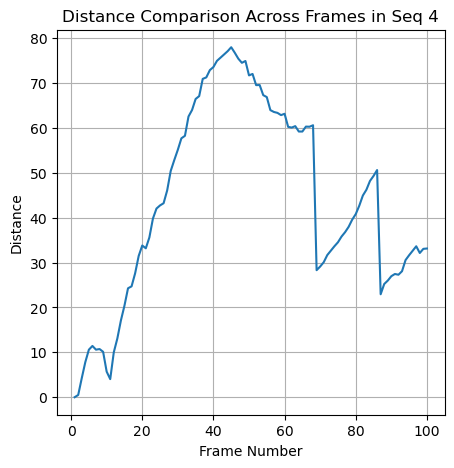

In [6]:
visualize_iou(detections_tm, groundtruth, "IOU Comparison Across Frames in Seq " + seq_index)
visualize_distance(detections_tm, groundtruth, "Distance Comparison Across Frames in Seq " + seq_index)

Propose Improvements to the work if possible: